# Best Model Analysis
This notebook prints the confusion matrix for our best performing model (MobileNet Version 6) for more in depth performance analysis.

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

DATASET_PATH = '/content/drive/My Drive/50.021 Artificial Intelligence Group Assignment'

%cd "/content/drive/My Drive/50.021 Artificial Intelligence Group Assignment"

import os
assert os.path.exists(DATASET_PATH), "[!] Dataset path does not exist. Please check the path."

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/12m4fX9cAr1HVdx1AB1mgPF26R9bqG4mk/50.021 Artificial Intelligence Group Assignment


In [2]:
%%capture
def is_running_in_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

if is_running_in_colab():
  %pip install lightning polars
  %pip install icecream rich tqdm

In [3]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import polars as pl
import numpy as np
import lightning as L
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from datetime import datetime

# Model imports
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from torchvision.transforms import v2

# Metrics imports
from torchmetrics import (
    Accuracy,
    F1Score,
    AUROC,
    ConfusionMatrix,
    Precision,
    Recall
)

# Lightning modules and callbacks
from lightning.pytorch.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    LearningRateMonitor
)
from pytorch_lightning.loggers import TensorBoardLogger

# Set random seeds for reproducibility
import random
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

## Copy over relevant classes

In [4]:
class ImageDataset(torch.utils.data.Dataset):
    """Dataset for loading and preprocessing garbage classification images."""

    def __init__(self, dataframe: pl.DataFrame, training=False, img_size=224):
        super().__init__()
        # Use the image_path column directly from the dataframe as it now contains full paths
        # to the preprocessed RGB images
        self.image_path = dataframe['image_path'].to_numpy().squeeze()
        self.garbage_type = dataframe.select('label').to_numpy().squeeze()
        self.garbage_to_idx = {garbage: i for i, garbage in enumerate(np.unique(self.garbage_type))}
        self.training = training
        self.img_size = img_size

        # Enhanced augmentation for training - can be simpler now since images are already preprocessed
        self.train_transforms = v2.Compose([
            v2.RandomHorizontalFlip(p=0.5),
            v2.RandomVerticalFlip(p=0.3),
            v2.RandomRotation(degrees=10),
            # Reduced augmentation as images are already preprocessed and augmented
        ])

        # Base transforms for all images
        self.transforms = v2.Compose([
            v2.ToDtype(torch.float32, scale=True),
        ])

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, idx):
        image_path = self.image_path[idx]

        try:
            # Load the image - now these are RGB processed images
            image = cv2.imread(image_path)
            if image is None:
                raise ValueError(f"Failed to load image at {image_path}")

            # Convert BGR to RGB (cv2 loads as BGR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Resize to the target size
            image = cv2.resize(image, (self.img_size, self.img_size))

            # Convert to tensor and reorder dimensions to [C, H, W]
            image = torch.from_numpy(image).float().permute(2, 0, 1)

            # Normalize to [0, 1]
            image = image / 255.0

            # Apply augmentations if in training mode
            if self.training:
                image = self.train_transforms(image)

            # Apply basic transforms
            image = self.transforms(image)

            # Get class label
            garbage = self.garbage_to_idx[self.garbage_type[idx]]

            return image, torch.tensor(garbage, dtype=torch.long)

        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            raise

In [5]:
class GarbageClassificationData(L.LightningDataModule):
    """Data module for garbage classification dataset."""

    def __init__(self, ws_root: Path = Path("."), batch_size=32, num_workers=0, img_size=224):
        super().__init__()

        self.batch_size = batch_size
        self.img_size = img_size

        # Updated paths to use the new RGB preprocessed images
        rgb_base_path = Path("/content/drive/My Drive/50.021 Artificial Intelligence Group Assignment/RGB_preprocessed_images")

        # Load datasets using the new CSV files
        self.train_ds = ImageDataset(
            pl.read_csv(rgb_base_path / 'train.csv'),
            training=True,
            img_size=self.img_size
        )
        self.val_ds = ImageDataset(
            pl.read_csv(rgb_base_path / 'validation.csv'),
            img_size=self.img_size
        )
        self.test_ds = ImageDataset(
            pl.read_csv(rgb_base_path / 'test.csv'),
            img_size=self.img_size
        )

        # Get class info
        self.n_classes = len(self.train_ds.garbage_to_idx)
        self.idx_to_garbage = {v: k for k, v in self.train_ds.garbage_to_idx.items()}

        # Print dataset statistics
        print(f"Number of training samples: {len(self.train_ds)}")
        print(f"Number of validation samples: {len(self.val_ds)}")
        print(f"Number of test samples: {len(self.test_ds)}")
        print(f"Number of classes: {self.n_classes}")
        print(f"Classes: {self.idx_to_garbage}")

        # DataLoader settings
        self.dataloader_extras = dict(
            num_workers=num_workers,
            pin_memory=True,
            persistent_workers=num_workers > 0
        )

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            shuffle=True,
            **self.dataloader_extras
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_ds,
            batch_size=self.batch_size*2,
            **self.dataloader_extras
        )

    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            self.test_ds,
            batch_size=self.batch_size*2,
            **self.dataloader_extras
        )

## Load saved model

In [6]:
class MobileNetV2_6(L.LightningModule):

    def __init__(self, n_classes, learning_rate=3e-4, weight_decay=1e-4):
        super().__init__()
        self.n_classes = n_classes
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.mixup_alpha = 0.2  # Parameter for mixup augmentation

        # Load pre-trained MobileNetV2 model
        self.model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)

        # Initialize frozen layer flags for progressive unfreezing
        self.unfreeze_stage = 0

        # Initially freeze all feature extraction layers
        for param in self.model.features.parameters():
            param.requires_grad = False

        # Get the number of features in the final layer
        in_features = self.model.classifier[1].in_features

        # Replace classifier with enhanced MLP head
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.4),  # Increased dropout rate
            nn.Linear(in_features, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),  # SiLU/Swish activation (better than ReLU)
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, n_classes)
        )

        # Use label smoothing cross entropy
        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

        # Initialize metrics
        self.train_acc = Accuracy(task="multiclass", num_classes=n_classes)
        self.val_acc = Accuracy(task="multiclass", num_classes=n_classes)

        # Test metrics
        self.test_accuracy = Accuracy(task="multiclass", num_classes=n_classes)
        self.test_precision = Precision(task="multiclass", num_classes=n_classes, average='macro')
        self.test_recall = Recall(task="multiclass", num_classes=n_classes, average='macro')
        self.test_f1 = F1Score(task="multiclass", num_classes=n_classes, average='macro')
        self.test_auroc = AUROC(task="multiclass", num_classes=n_classes)
        self.test_confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=n_classes)

        # Save hyperparameters
        self.save_hyperparameters()

    def mixup_data(self, x, y):
        """Apply mixup augmentation to the batch."""
        if self.training and self.mixup_alpha > 0:
            lam = np.random.beta(self.mixup_alpha, self.mixup_alpha)
            batch_size = x.size()[0]
            index = torch.randperm(batch_size).to(x.device)

            mixed_x = lam * x + (1 - lam) * x[index, :]
            y_a, y_b = y, y[index]
            return mixed_x, y_a, y_b, lam
        else:
            return x, y, y, 1.0

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch

        # Apply mixup if training
        if self.training:
            x, y_a, y_b, lam = self.mixup_data(x, y)
            y_pred = self(x)
            loss = lam * self.criterion(y_pred, y_a) + (1 - lam) * self.criterion(y_pred, y_b)
        else:
            y_pred = self(x)
            loss = self.criterion(y_pred, y)

        # Calculate and log metrics
        preds = torch.argmax(y_pred, dim=1)
        acc = self.train_acc(preds, y)

        # Log metrics
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)

        # Calculate metrics
        preds = torch.argmax(y_pred, dim=1)
        acc = self.val_acc(preds, y)

        # Log metrics
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_epoch=True, prog_bar=True)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)

        # Calculate predictions
        preds = torch.argmax(y_pred, dim=1)
        probs = torch.softmax(y_pred, dim=1)

        # Update metrics
        self.test_accuracy(preds, y)
        self.test_precision(preds, y)
        self.test_recall(preds, y)
        self.test_f1(preds, y)
        self.test_auroc(probs, y)
        self.test_confusion_matrix(preds, y)

        # Log metrics
        self.log('test_loss', loss, on_epoch=True)

        return loss

    def on_test_epoch_end(self):
        # Compute and log final metrics
        accuracy = self.test_accuracy.compute()
        precision = self.test_precision.compute()
        recall = self.test_recall.compute()
        f1_score = self.test_f1.compute()
        auroc = self.test_auroc.compute()
        conf_mat = self.test_confusion_matrix.compute().cpu().numpy()

        # Store metrics in self for access after training
        self.final_metrics = {
            'accuracy': accuracy.item(),
            'precision': precision.item(),
            'recall': recall.item(),
            'f1': f1_score.item(),
            'auroc': auroc.item()
        }

        # Print detailed metrics
        print("\n--- Test Metrics ---")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1_score:.4f}")
        print(f"AUROC: {auroc:.4f}")

        # Reset metrics
        self.test_accuracy.reset()
        self.test_precision.reset()
        self.test_recall.reset()
        self.test_f1.reset()
        self.test_auroc.reset()
        self.test_confusion_matrix.reset()

    def on_train_epoch_start(self):
        """
        Progressive unfreezing of layers based on training epoch.
        """
        # Get total number of blocks in MobileNetV2 features
        total_blocks = len(self.model.features)

        if self.current_epoch == 3 and self.unfreeze_stage == 0:
            # Unfreeze the last 30% of feature layers after 3 epochs
            unfreeze_from = int(total_blocks * 0.7)
            for i in range(unfreeze_from, total_blocks):
                for param in self.model.features[i].parameters():
                    param.requires_grad = True
            print(f"Unfreezing layers from {unfreeze_from} to {total_blocks-1}")
            self.unfreeze_stage = 1

        elif self.current_epoch == 6 and self.unfreeze_stage == 1:
            # Unfreeze more layers after 6 epochs
            unfreeze_from = int(total_blocks * 0.4)
            for i in range(unfreeze_from, total_blocks):
                for param in self.model.features[i].parameters():
                    param.requires_grad = True
            print(f"Unfreezing layers from {unfreeze_from} to {total_blocks-1}")
            self.unfreeze_stage = 2

        elif self.current_epoch == 9 and self.unfreeze_stage == 2:
            # Unfreeze all layers after 9 epochs
            for i in range(total_blocks):
                for param in self.model.features[i].parameters():
                    param.requires_grad = True
            print("Unfreezing all layers")
            self.unfreeze_stage = 3

    def configure_optimizers(self):
        """
        Configure optimizer with weight decay and learning rate scheduler.
        """
        # Create optimizer with weight decay
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.learning_rate,
            weight_decay=self.weight_decay
        )

        # OneCycleLR scheduler
        scheduler = {
            "scheduler": OneCycleLR(
                optimizer,
                max_lr=self.learning_rate,
                total_steps=self.trainer.estimated_stepping_batches,
                pct_start=0.1,  # 10% warmup
                div_factor=25,  # initial_lr = max_lr/25
                final_div_factor=1000,  # min_lr = initial_lr/1000
            ),
            "interval": "step",
            "frequency": 1
        }

        return {"optimizer": optimizer, "lr_scheduler": scheduler}

In [7]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [8]:
model = torch.load("saved_mobilenet/mobilenetv2-method6.pth", map_location=device, weights_only=False)
model.to(device)
model.eval()

MobileNetV2_6(
  (model): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1

# Generate Confusion Matrix

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
from tqdm.auto import tqdm

def generate_confusion_matrix(model, data_loader, device, num_classes):
    """
    Generate a confusion matrix for the model on the given data loader.

    Args:
        model: The trained model
        data_loader: DataLoader containing test data
        device: Device to run inference on
        num_classes: Number of classes in the dataset

    Returns:
        confusion_matrix: The generated confusion matrix
    """
    # Set model to evaluation mode
    model.eval()

    # Initialize confusion matrix
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)

    # Collect all predictions and labels
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc="Evaluating"):
            # Move data to device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)

            # Get predictions
            _, preds = torch.max(outputs, 1)

            # Save predictions and labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Generate confusion matrix
    for pred, label in zip(all_preds, all_labels):
        confusion_matrix[label, pred] += 1

    return confusion_matrix

def plot_confusion_matrix(confusion_matrix, class_names):
    """
    Plot and save a confusion matrix with class names.

    Args:
        confusion_matrix: The confusion matrix to plot
        class_names: List of class names for the axes
    """
    plt.figure(figsize=(12, 10))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig("mobilenetv2_confusion_matrix.png", dpi=300)
    plt.show()

In [10]:
data_module = GarbageClassificationData(
    batch_size=32,  # Use same batch size as training or larger if memory allows
    num_workers=4,  # Adjust based on your system
    img_size=224    # Same as used during training
)
data_module.setup("test")

Number of training samples: 12670
Number of validation samples: 1091
Number of test samples: 1090
Number of classes: 8
Classes: {0: 'Glass', 1: 'Hazardous Waste', 2: 'Metal', 3: 'Organic Waste', 4: 'Paper & Cardboard', 5: 'Plastic', 6: 'Textiles', 7: 'Trash'}


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

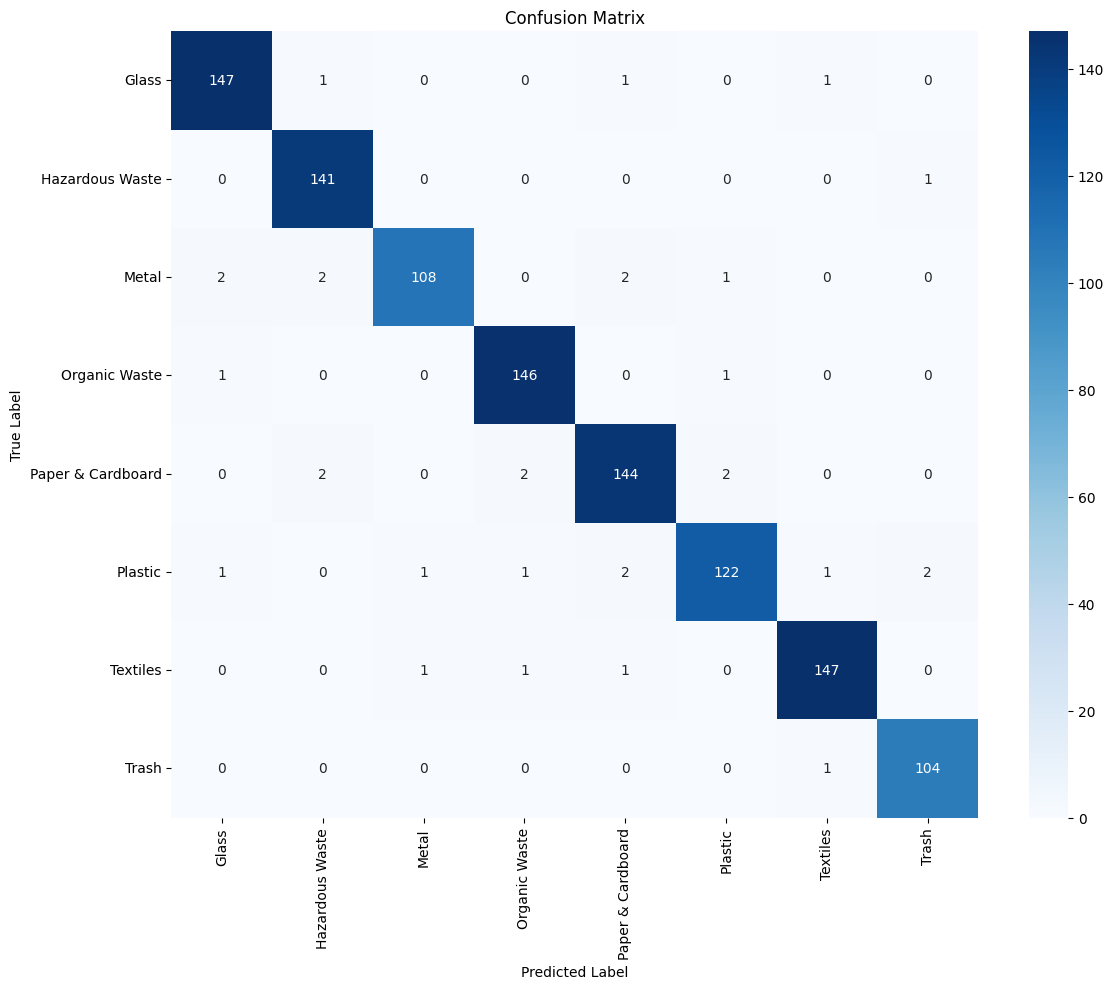


=== Per-Class Metrics ===
            Class  Precision  Recall  F1 Score
            Glass     0.9735  0.9800    0.9767
  Hazardous Waste     0.9658  0.9930    0.9792
            Metal     0.9818  0.9391    0.9600
    Organic Waste     0.9733  0.9865    0.9799
Paper & Cardboard     0.9600  0.9600    0.9600
          Plastic     0.9683  0.9385    0.9531
         Textiles     0.9800  0.9800    0.9800
            Trash     0.9720  0.9905    0.9811

=== Overall Metrics ===
         Metric  Value
       Accuracy 0.9716
Macro Precision 0.9718
   Macro Recall 0.9709
 Macro F1 Score 0.9713


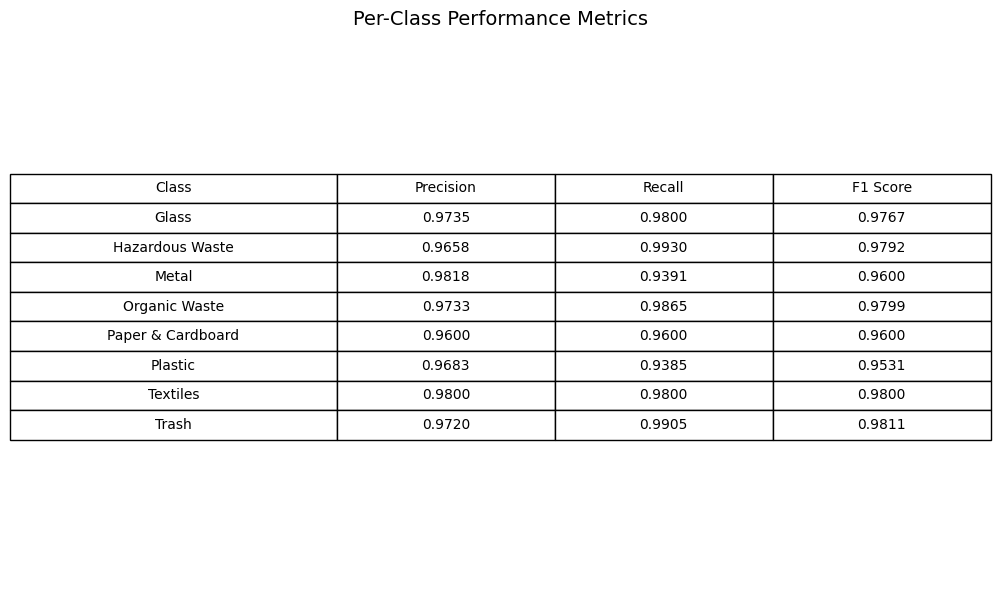

In [21]:
# Get class names
idx_to_garbage = data_module.idx_to_garbage
class_names = [idx_to_garbage[i] for i in range(len(idx_to_garbage))]
num_classes = len(class_names)

# Generate confusion matrix
test_loader = data_module.test_dataloader()
conf_matrix = generate_confusion_matrix(model, test_loader, device, num_classes)

# Plot and save confusion matrix
plot_confusion_matrix(conf_matrix, class_names)

# Calculate per-class metrics
precision_per_class = np.zeros(num_classes)
recall_per_class = np.zeros(num_classes)
f1_per_class = np.zeros(num_classes)

for i in range(num_classes):
    # True positives are on the diagonal
    tp = conf_matrix[i, i]
    # False positives are in the column (excluding true positive)
    fp = np.sum(conf_matrix[:, i]) - tp
    # False negatives are in the row (excluding true positive)
    fn = np.sum(conf_matrix[i, :]) - tp

    # Calculate metrics
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    precision_per_class[i] = precision
    recall_per_class[i] = recall
    f1_per_class[i] = f1

# Create a DataFrame for per-class metrics
import pandas as pd
metrics_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1 Score': f1_per_class
})

# Display the table with formatted metrics
pd.set_option('display.precision', 4)  # Set display precision to 4 decimal places
print("\n=== Per-Class Metrics ===")
print(metrics_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# Calculate and print overall metrics
accuracy = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)
macro_precision = np.mean(precision_per_class)
macro_recall = np.mean(recall_per_class)
macro_f1 = np.mean(f1_per_class)

# Create a DataFrame for overall metrics
overall_metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Macro Precision', 'Macro Recall', 'Macro F1 Score'],
    'Value': [accuracy, macro_precision, macro_recall, macro_f1]
})

print("\n=== Overall Metrics ===")
print(overall_metrics_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# Optional: Create a visual table with matplotlib
plt.figure(figsize=(10, 6))
plt.axis('off')
table = plt.table(
    cellText=np.column_stack((
        class_names,
        [f"{x:.4f}" for x in precision_per_class],
        [f"{x:.4f}" for x in recall_per_class],
        [f"{x:.4f}" for x in f1_per_class]
    )),
    colLabels=['Class', 'Precision', 'Recall', 'F1 Score'],
    loc='center',
    cellLoc='center',
    colWidths=[0.3, 0.2, 0.2, 0.2]
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)
plt.title("Per-Class Performance Metrics", fontsize=14)
plt.tight_layout()
plt.savefig("class_metrics_table.png", dpi=300, bbox_inches='tight')
plt.show()

# Error Analysis Heatmap

In [12]:
def generate_error_analysis_heatmap(confusion_matrix, class_names):
    """Generate a normalized heatmap showing error patterns."""
    # Normalize by row (true labels)
    row_sums = confusion_matrix.sum(axis=1, keepdims=True)
    norm_conf_matrix = confusion_matrix / row_sums

    # Create a mask for the diagonal (correct predictions)
    np.fill_diagonal(norm_conf_matrix, 0)

    plt.figure(figsize=(12, 10))
    sns.heatmap(norm_conf_matrix, annot=True, fmt='.2f', cmap='Reds',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Error Distribution (Normalized Confusion Matrix with Diagonal Removed)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig("error_heatmap.png", dpi=300)
    plt.show()

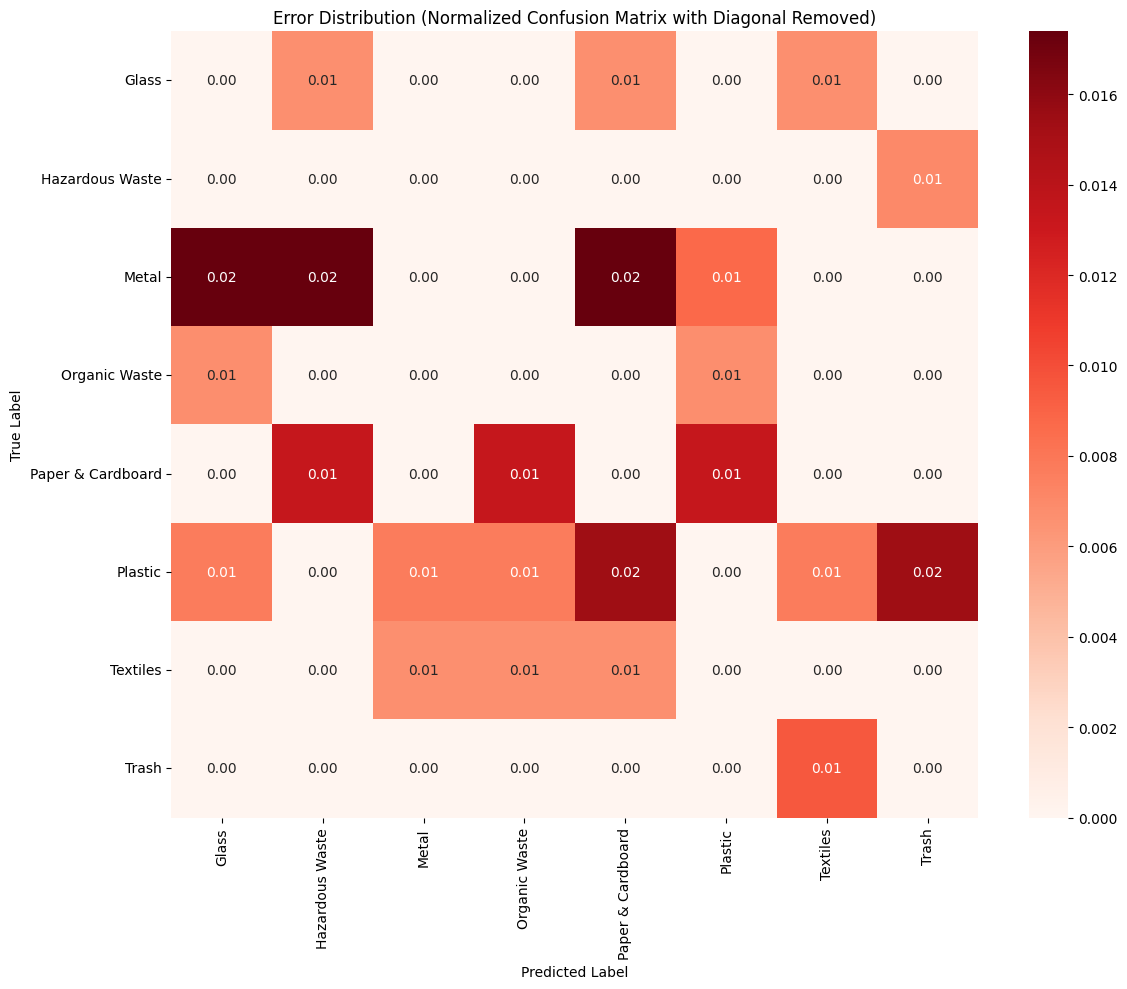

In [13]:
# Get class names from the data module
idx_to_garbage = data_module.idx_to_garbage
class_names = [idx_to_garbage[i] for i in range(len(idx_to_garbage))]

# Now call the function with both required arguments
generate_error_analysis_heatmap(conf_matrix, class_names)

# Confidence Analysis

In [14]:
def analyze_prediction_confidence(model, data_loader, device, class_names):
    """Analyze the confidence of predictions by class."""
    model.eval()
    correct_confidences = [[] for _ in range(len(class_names))]
    incorrect_confidences = [[] for _ in range(len(class_names))]

    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc="Analyzing confidence"):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)

            # Get max probability (confidence) and predicted class
            confidences, preds = torch.max(probabilities, dim=1)

            # Store confidences by true class
            for i, (conf, pred, label) in enumerate(zip(confidences, preds, labels)):
                if pred == label:
                    correct_confidences[label.item()].append(conf.item())
                else:
                    incorrect_confidences[label.item()].append(conf.item())

    # Plot average confidence by class
    avg_correct_conf = [np.mean(confs) if confs else 0 for confs in correct_confidences]
    avg_incorrect_conf = [np.mean(confs) if confs else 0 for confs in incorrect_confidences]

    plt.figure(figsize=(12, 6))
    x = np.arange(len(class_names))
    width = 0.35

    plt.bar(x - width/2, avg_correct_conf, width, label='Correct Predictions')
    plt.bar(x + width/2, avg_incorrect_conf, width, label='Incorrect Predictions')

    plt.xlabel('Class')
    plt.ylabel('Average Confidence')
    plt.title('Average Prediction Confidence by Class')
    plt.xticks(x, class_names, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.savefig("confidence_analysis.png", dpi=300)
    plt.show()

    # Histogram of confidences for correct vs incorrect predictions
    plt.figure(figsize=(10, 6))

    # Flatten lists for histogram
    all_correct_conf = [conf for confs in correct_confidences for conf in confs]
    all_incorrect_conf = [conf for confs in incorrect_confidences for conf in confs]

    plt.hist(all_correct_conf, bins=20, alpha=0.6, label='Correct Predictions')
    plt.hist(all_incorrect_conf, bins=20, alpha=0.6, label='Incorrect Predictions')

    plt.xlabel('Confidence Score')
    plt.ylabel('Number of Predictions')
    plt.title('Distribution of Confidence Scores')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("confidence_histogram.png", dpi=300)
    plt.show()

Analyzing confidence:   0%|          | 0/18 [00:00<?, ?it/s]

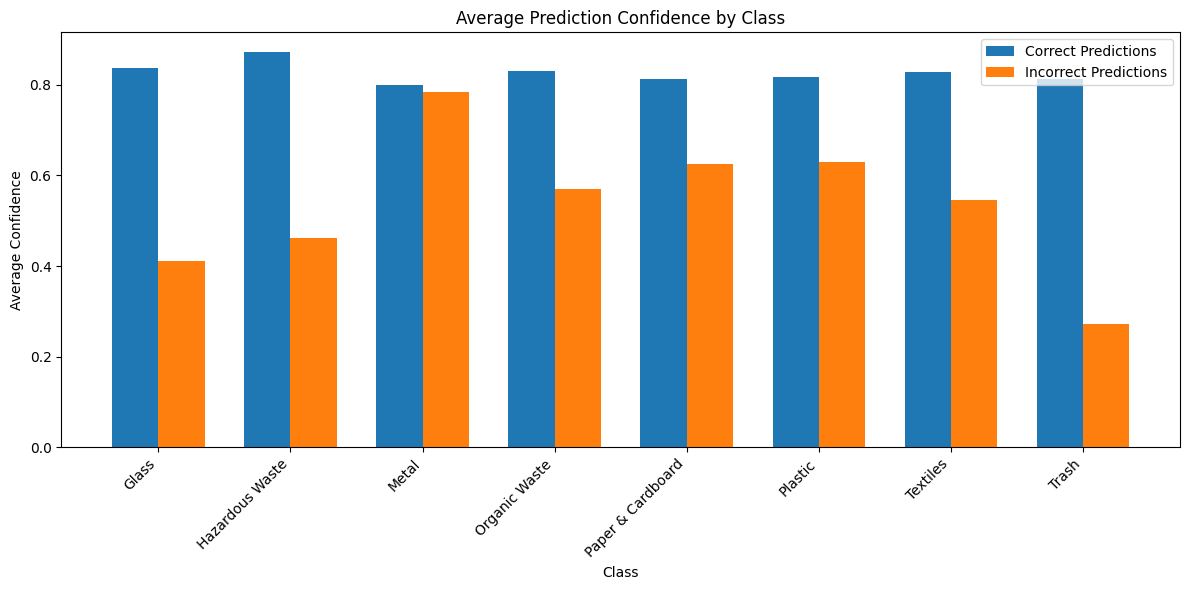

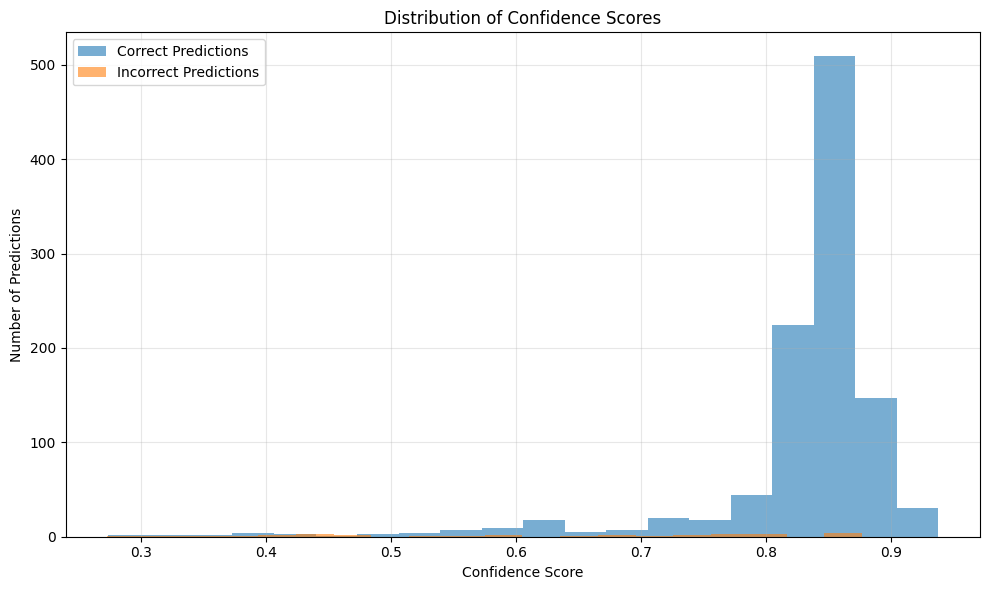

In [15]:
analyze_prediction_confidence(model, test_loader, device, class_names)

# Misclassification Analysis with Examples

In [16]:
def show_misclassified_examples(model, data_loader, device, class_names, num_examples=16):
    """Show examples of misclassified images."""
    model.eval()
    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            # Find misclassified examples
            incorrect_mask = (preds != labels)

            if incorrect_mask.sum() > 0:
                incorrect_images = images[incorrect_mask]
                incorrect_labels = labels[incorrect_mask]
                incorrect_preds = preds[incorrect_mask]

                for img, true_label, pred_label in zip(incorrect_images, incorrect_labels, incorrect_preds):
                    misclassified_images.append(img.cpu())
                    misclassified_labels.append(true_label.item())
                    misclassified_preds.append(pred_label.item())

                    if len(misclassified_images) >= num_examples:
                        break

            if len(misclassified_images) >= num_examples:
                break

    # Display the misclassified images
    num_to_show = min(len(misclassified_images), num_examples)
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 16))
    axes = axes.flatten()

    for i in range(num_to_show):
        img = misclassified_images[i].permute(1, 2, 0).numpy()
        # Denormalize if needed
        img = np.clip(img, 0, 1)

        # Show the image and add labels
        axes[i].imshow(img)
        axes[i].set_title(f"True: {class_names[misclassified_labels[i]]}\n"
                          f"Pred: {class_names[misclassified_preds[i]]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.savefig("misclassified_examples.png", dpi=300)
    plt.show()

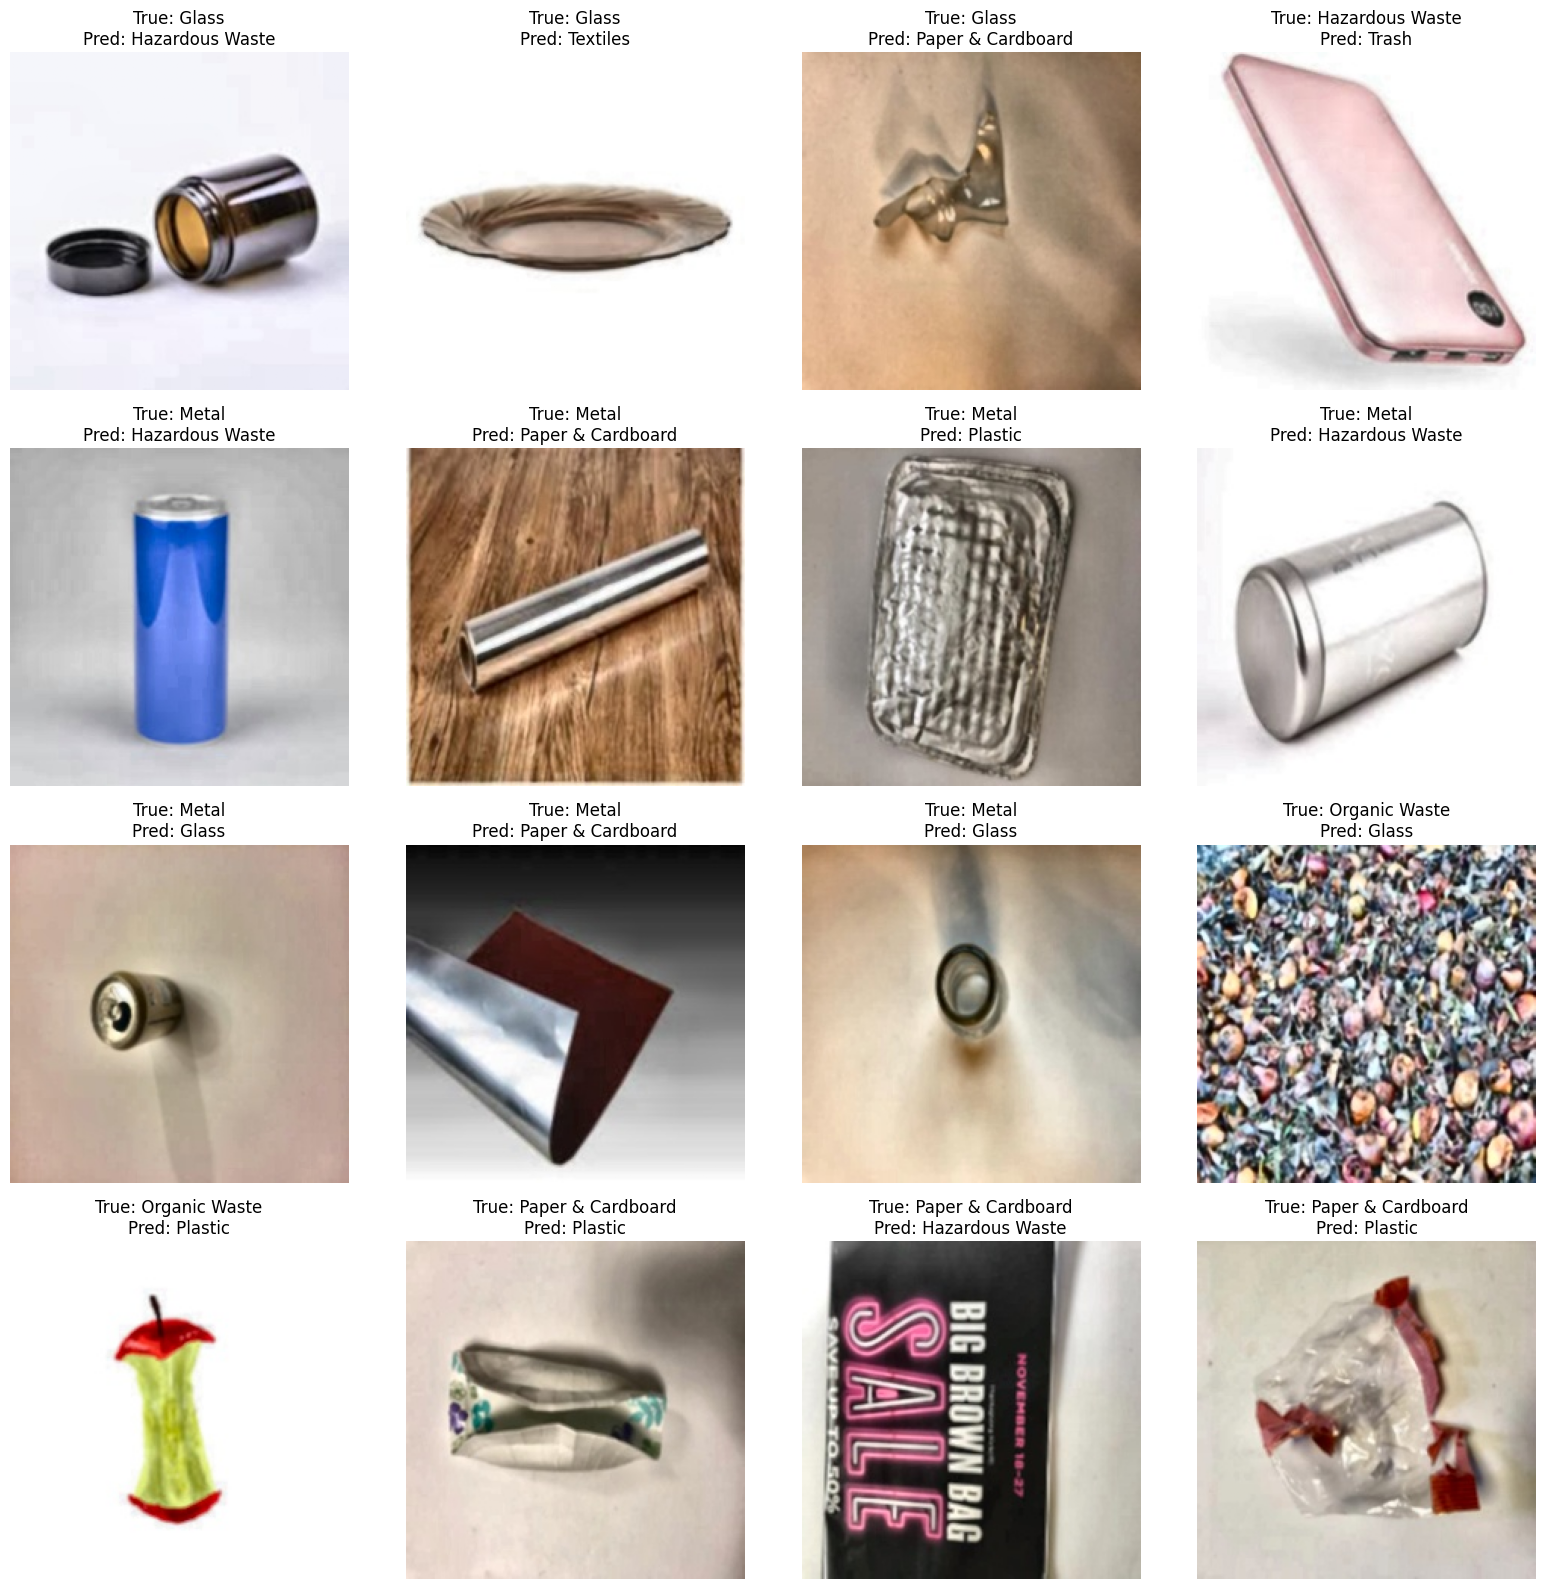

In [17]:
show_misclassified_examples(model, test_loader, device, class_names, num_examples=16)